In [1]:
from sklearn.datasets import make_regression
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
n_samples = 2000  
n_features = 10   
n_informative = 6


X, y = make_regression(n_samples=n_samples, n_features=n_features, n_informative=n_informative, noise=0.1, random_state=42)

df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(n_features)])
df["target"] = y

df.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,-0.113592,1.745859,-0.141709,-0.753204,0.877826,-1.768131,2.992811,-0.022030,0.722675,0.790759,79.973249
1,-1.049655,0.506241,-0.397195,0.568103,-1.102270,0.355669,0.191577,0.086698,1.447306,0.347562,-47.253072
2,-1.428905,-2.152914,-1.085748,-0.561930,0.029796,-0.734811,-1.399228,1.483744,-0.030787,-0.640154,-2.404218
3,0.527839,-1.345335,-0.628670,0.505337,-2.618133,0.135190,-0.326234,-1.339470,-0.281164,-1.481581,-493.122773
4,-1.091047,1.073340,-1.156127,-0.311208,-1.108765,-0.352593,0.700972,1.602844,0.814684,0.367360,41.375436


In [2]:
res = pd.DataFrame(columns = ["m", "mse"])
print(res)

Empty DataFrame
Columns: [m, mse]
Index: []


In [3]:
from itertools import combinations
m_values = range(1, 11)
min = float("+inf")
min_comb = None
for m in m_values:
    for feature_indices in combinations(range(n_features), m):
        X_m = df.iloc[:, list(feature_indices)]
        model = LinearRegression()

        neg_mse_scores = cross_val_score(model, X_m, df["target"], cv=5, scoring="neg_mean_squared_error")
        mse = -neg_mse_scores.mean() 
        if mse < min:
            min_comb = feature_indices
            min = mse
        res.loc[len(res)] =  [m, mse]

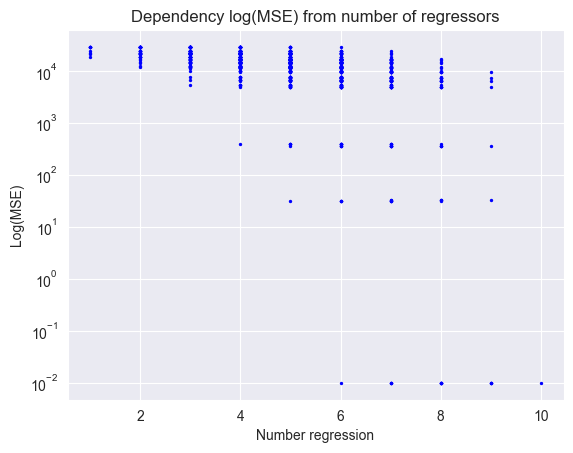

In [4]:
plt.scatter(res["m"], res["mse"], color='blue', marker='o', s =2)
plt.xlabel("Number regression")
plt.ylabel("Log(MSE)")
plt.yscale("log")
plt.title("Dependency log(MSE) from number of regressors")
plt.grid(True)
plt.show()


In [5]:
min_comb

(2, 4, 5, 6, 7, 9)

In [12]:
from scipy.stats import chi2_contingency, jarque_bera
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
import scipy.stats as stats

In [13]:
model = LinearRegression()
X_relevant = df.iloc[:, list(min_comb)]
model.fit(X_relevant, df["target"])

# Получаем предсказания и вычисляем остатки
y_pred = model.predict(X_relevant)
residuals = y_pred - df["target"]

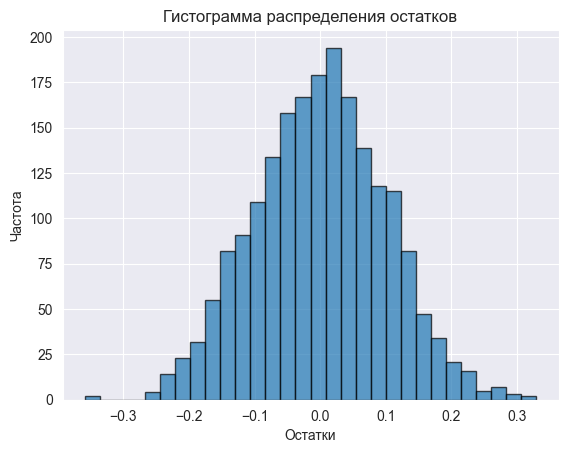

In [14]:
# Гистограмма остатков
plt.hist(residuals, bins=30, edgecolor="k", alpha=0.7)
plt.title("Гистограмма распределения остатков")
plt.xlabel("Остатки")
plt.ylabel("Частота")
plt.show()

In [15]:
residuals = residuals[residuals > -0.3]
len_res = len(residuals)
len_res

1998

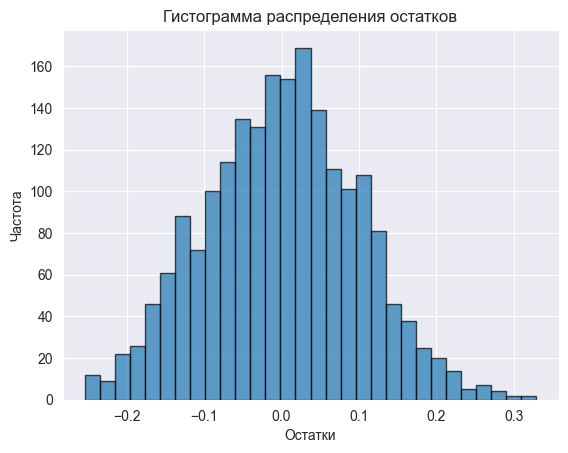

In [16]:
plt.hist(residuals, bins=30, edgecolor="k", alpha=0.7)
plt.title("Гистограмма распределения остатков")
plt.xlabel("Остатки")
plt.ylabel("Частота")
plt.show()

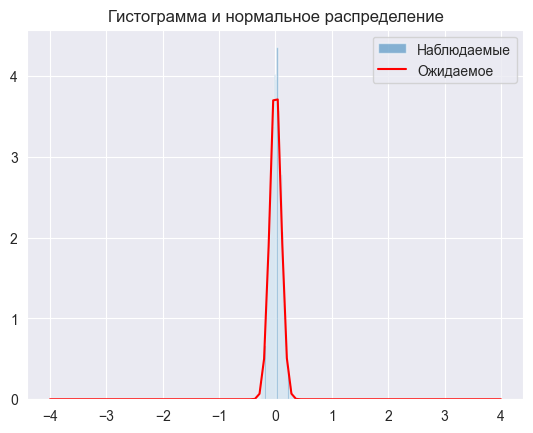

Статистика хи-квадрат: 34.41
p-value: 0.1544


In [18]:
data = residuals
num_bins = 30
observed_freq, bin_edges = np.histogram(data, bins=num_bins)
mean = np.mean(data)
std_dev = np.std(data)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # Центры интервалов
expected_freq = np.array([stats.norm(mean, std_dev).pdf(x) * len(data) * (bin_edges[i+1] - bin_edges[i]) for i, x in enumerate(bin_centers)])

# Вычисление статистики хи-квадрат
chi_squared_stat = np.sum((observed_freq - expected_freq) ** 2 / expected_freq)

# Степени свободы
degrees_of_freedom = num_bins - 1 - 2  # минус 1 для интервалов, минус 2 для оценки параметров

# p-value
p_value = 1 - stats.chi2.cdf(chi_squared_stat, degrees_of_freedom)

# Визуализация
plt.hist(data, bins=num_bins, alpha=0.5, label='Наблюдаемые', density=True)
x = np.linspace(-4, 4, 100)
plt.plot(x, stats.norm.pdf(x, mean, std_dev), 'r-', label='Ожидаемое')
plt.title('Гистограмма и нормальное распределение')
plt.legend()
plt.show()

print(f'Статистика хи-квадрат: {chi_squared_stat:.2f}')
print(f'p-value: {p_value:.4f}')

In [19]:
hbg_stat, p_value_hbg = sm.stats.normal_ad(residuals)
print(f'Критерий Харке-Бера: статистика = {hbg_stat}, p-value = {p_value_hbg}')
alpha = 0.05
if p_value_hbg < alpha:
    print("Отвергаем нулевую гипотезу для критерия Харке-Бера: остатки не нормально распределены.")
else:
    print("Нет оснований отвергать нулевую гипотезу для критерия Харке-Бера: остатки нормально распределены.")

Критерий Харке-Бера: статистика = 0.551887180900394, p-value = 0.15484219453771195
Нет оснований отвергать нулевую гипотезу для критерия Харке-Бера: остатки нормально распределены.


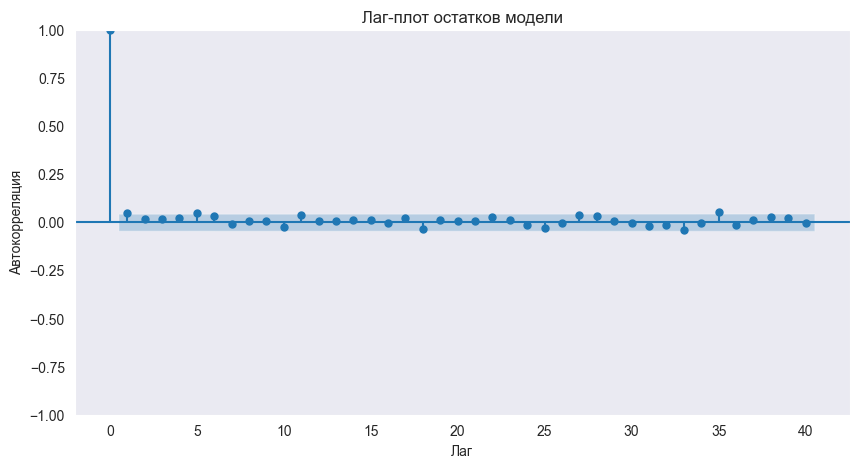

Статистика Дарбина-Уотсона: 1.9046782368425652
Автокорреляция отсутствует.


In [20]:
plt.figure(figsize=(10, 5))
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('Лаг-плот остатков модели')
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.grid()
plt.show()

# Проверка на автокорреляцию с помощью критерия Дарбина-Уотсона
dw_stat = durbin_watson(residuals)
print(f'Статистика Дарбина-Уотсона: {dw_stat}')
if dw_stat < 1.5:
    print("Наблюдается положительная автокорреляция.")
elif dw_stat > 2.5:
    print("Наблюдается отрицательная автокорреляция.")
else:
    print("Автокорреляция отсутствует.")

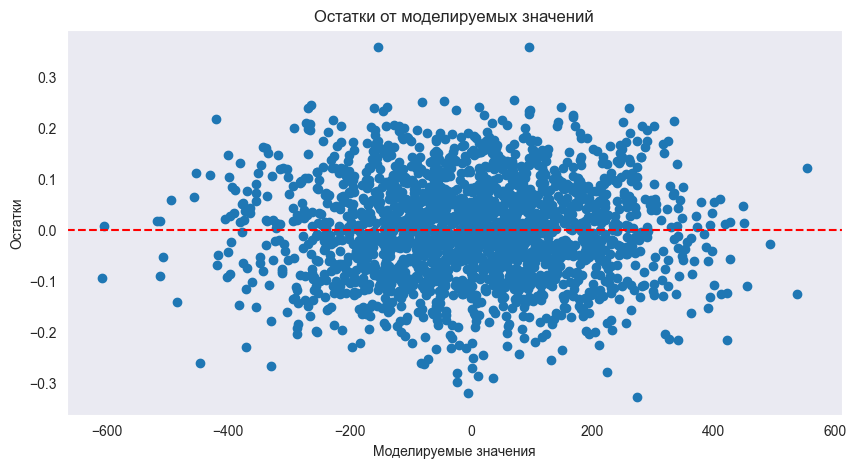

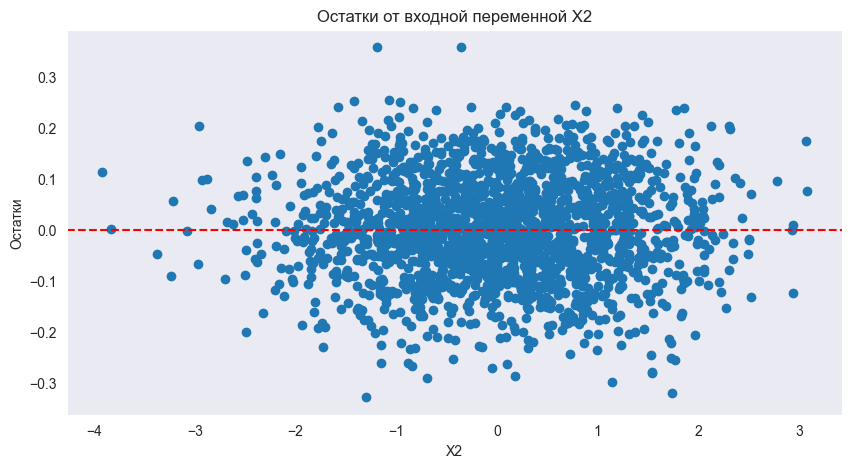

Коэффициенты регрессии модулей остатков на первую переменную: const        0.079881
feature_2    0.002393
dtype: float64
Доверительные интервалы для коэффициентов:
                  0         1
const      0.077266  0.082496
feature_2 -0.000173  0.004958
Статистика критерия Бройша-Пагана: 2.1609125433652565
p-value: 0.14156059847968175
Гетероскедастичность не обнаружена: принимаем нулевую гипотезу о равенстве дисперсий остатков.


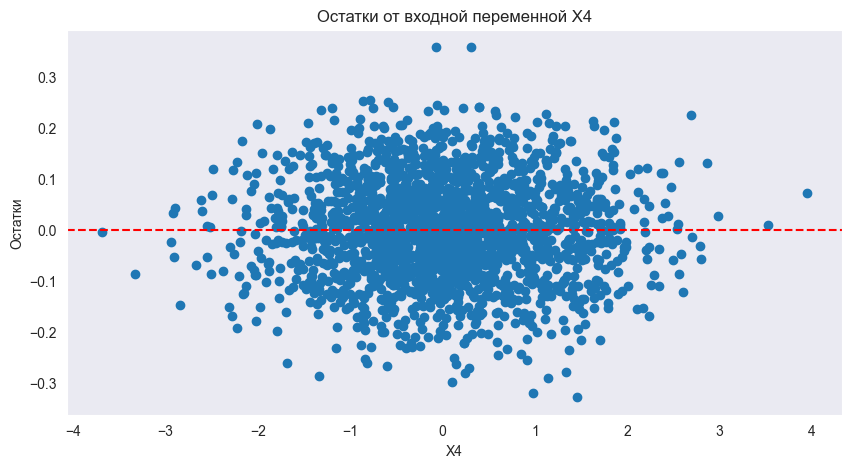

Коэффициенты регрессии модулей остатков на первую переменную: const        0.079942
feature_4   -0.000315
dtype: float64
Доверительные интервалы для коэффициентов:
                  0         1
const      0.077325  0.082559
feature_4 -0.002963  0.002332
Статистика критерия Бройша-Пагана: 0.02270446311913865
p-value: 0.8802281488884707
Гетероскедастичность не обнаружена: принимаем нулевую гипотезу о равенстве дисперсий остатков.


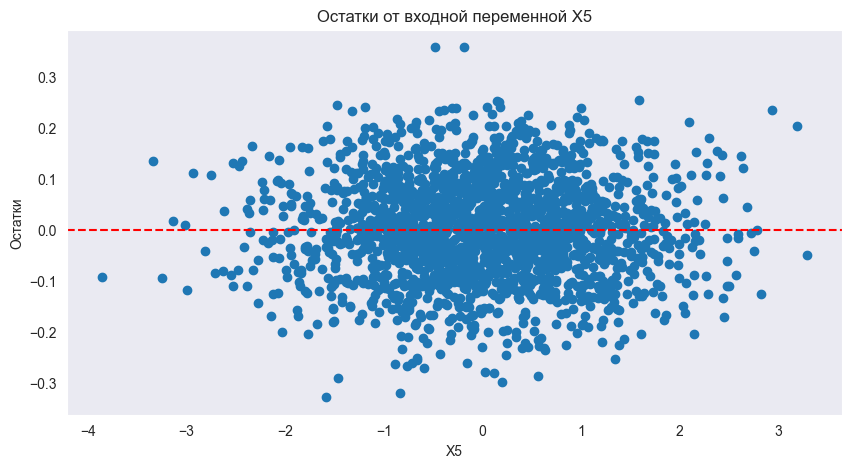

Коэффициенты регрессии модулей остатков на первую переменную: const        0.079938
feature_5   -0.000482
dtype: float64
Доверительные интервалы для коэффициентов:
                  0         1
const      0.077322  0.082555
feature_5 -0.003075  0.002111
Статистика критерия Бройша-Пагана: 0.037669814123564294
p-value: 0.8461076586018001
Гетероскедастичность не обнаружена: принимаем нулевую гипотезу о равенстве дисперсий остатков.


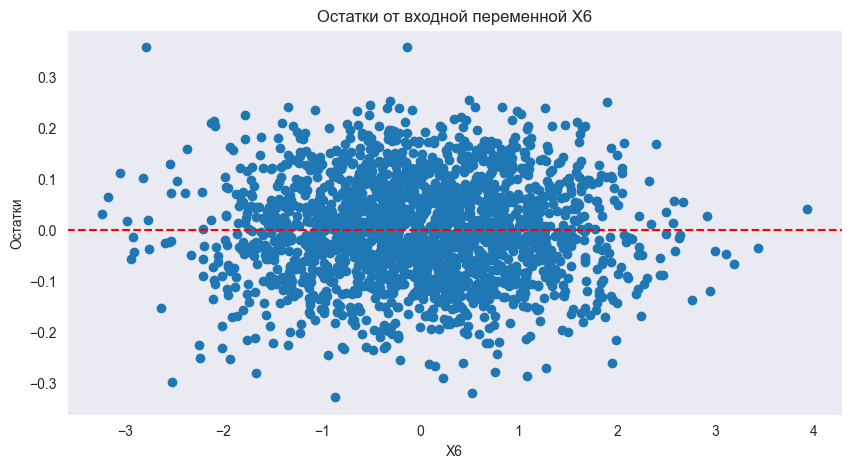

Коэффициенты регрессии модулей остатков на первую переменную: const        0.079937
feature_6   -0.000337
dtype: float64
Доверительные интервалы для коэффициентов:
                  0         1
const      0.077320  0.082553
feature_6 -0.002903  0.002228
Статистика критерия Бройша-Пагана: 1.057838765854635
p-value: 0.3037086303845966
Гетероскедастичность не обнаружена: принимаем нулевую гипотезу о равенстве дисперсий остатков.


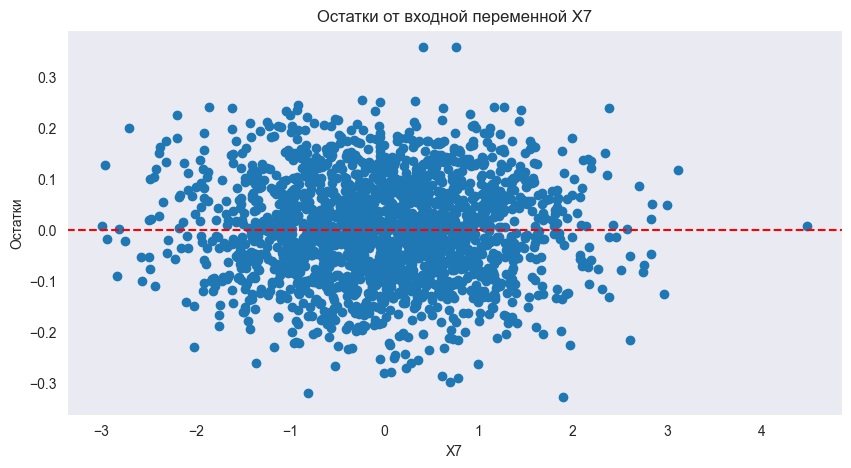

Коэффициенты регрессии модулей остатков на первую переменную: const        0.079939
feature_7    0.000308
dtype: float64
Доверительные интервалы для коэффициентов:
                  0         1
const      0.077322  0.082556
feature_7 -0.002331  0.002947
Статистика критерия Бройша-Пагана: 0.09938487832306109
p-value: 0.7525690564431812
Гетероскедастичность не обнаружена: принимаем нулевую гипотезу о равенстве дисперсий остатков.


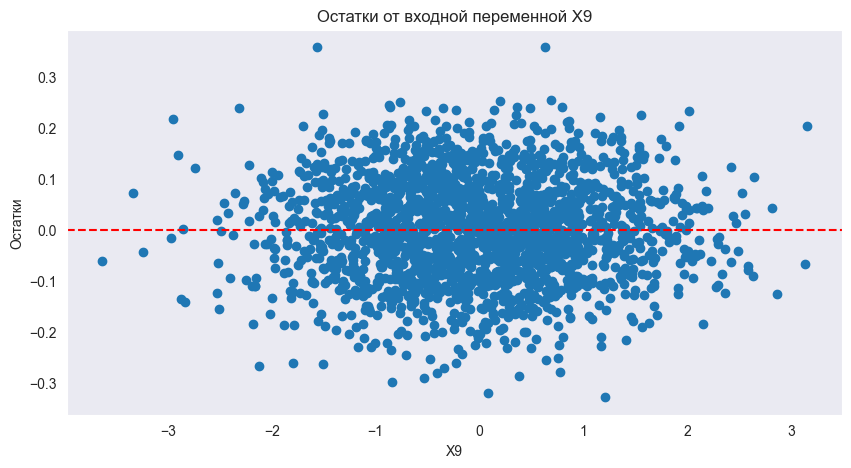

Коэффициенты регрессии модулей остатков на первую переменную: const        0.079816
feature_9   -0.003032
dtype: float64
Доверительные интервалы для коэффициентов:
                  0         1
const      0.077200  0.082431
feature_9 -0.005648 -0.000417
Статистика критерия Бройша-Пагана: 3.8730978167302865
p-value: 0.04906587990026716
Гетероскедастичность присутствует: отвергаем нулевую гипотезу о равенстве дисперсий остатков.


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

Y = df["target"]
X_relevant = df.iloc[:, list(min_comb)]

model = sm.OLS(Y, X_relevant).fit()
predictions = model.predict(X_relevant)
residuals = model.resid

# График остатков от моделируемых значений
plt.figure(figsize=(10, 5))
plt.scatter(predictions, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Остатки от моделируемых значений')
plt.xlabel('Моделируемые значения')
plt.ylabel('Остатки')
plt.grid()
plt.show()
absolute_residuals = np.abs(residuals)
# Графики остатков от каждой входной переменной
for i in min_comb:  # Для X1 до X6
    plt.figure(figsize=(10, 5))
    X_regressor = df.iloc[:, [i]]
    plt.scatter(X_regressor, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Остатки от входной переменной X{i}')
    plt.xlabel(f'X{i}')
    plt.ylabel('Остатки')
    plt.grid()
    plt.show()
    
    X_regressor_with_constant = sm.add_constant(X_regressor)
    absolute_model = sm.OLS(absolute_residuals, X_regressor_with_constant).fit()
    #Получаем предсказания и доверительные интервалы
    params = absolute_model.params
    confidence_intervals = absolute_model.conf_int(alpha=0.05)
    
    print("Коэффициенты регрессии модулей остатков на первую переменную:", params)
    print("Доверительные интервалы для коэффициентов:")
    print(confidence_intervals)
    bp_test = het_breuschpagan(residuals, X_regressor_with_constant)
    print("Статистика критерия Бройша-Пагана:", bp_test[0])
    print("p-value:", bp_test[1])

    if bp_test[1] < 0.05:
        print("Гетероскедастичность присутствует: отвергаем нулевую гипотезу о равенстве дисперсий остатков.")
    else:
        print("Гетероскедастичность не обнаружена: принимаем нулевую гипотезу о равенстве дисперсий остатков.")

In [ ]:
#TODO нормально заботать линейную регрессию, хи-квадрат тест и прочие тесты